In [113]:
# make the master files

import pandas as pd
import os

years = ['2015', '2016', '2017', '2018', '2019', '2020', '2021']
file_prefixes = ['FioName', 'FioTable', 'WorkHours']

name_df = pd.DataFrame()
table_df = pd.DataFrame()
work_df = pd.DataFrame()

directory = 'policeOvertime2015-2021Data'

for year in years:
    for prefix in file_prefixes:
        file_path = os.path.join(directory, f'{year}{prefix}.csv')
        if os.path.exists(file_path):
            if prefix == 'FioName':
                name_df = pd.concat([name_df, pd.read_csv(file_path)])
            elif prefix == 'FioTable':
                table_df = pd.concat([table_df, pd.read_csv(file_path)])
            elif prefix == 'WorkHours':
                work_df = pd.concat([work_df, pd.read_csv(file_path)])

name_df.to_csv(os.path.join('.', 'name.csv'), index=False)
table_df.to_csv(os.path.join('.', 'table.csv'), index=False)
work_df.to_csv(os.path.join('.', 'work.csv'), index=False)


In [114]:
# refine the master files

name_df = pd.read_csv('name.csv')
table_df = pd.read_csv('table.csv')
work_df = pd.read_csv('work.csv')

name_columns = ['recnum', 'fc_num', 'sex', 'race', 'age', 'complexion', 'ethnicity', 'skin_tone', 'deceased', 'frisk/search', 'person_id', 'was_frisked']
table_columns = ['fc_num', 'contact_officer', 'contact_officer_name', 'frisked', 'searchperson', 'searchvehicle', 'summonsissued', 'stop_duration', 'circumstance', 'basis']
work_columns = ['Emp. ID', 'Employee', 'Hours_Worked', 'Hours_Paid']

name_df = name_df[name_columns]
table_df = table_df[table_columns]
work_df = work_df[work_columns]

work_df['Hours_Worked'] = work_df['Hours_Worked'].apply(lambda x: (x // 100) + ((x % 100) / 60))

work_df.columns = ['emp_id', 'emp_name', 'hours_worked', 'hours_paid']
table_df.columns = ['fc_num', 'emp_id', 'emp_name', 'frisked', 'searchperson', 'searchvehicle', 'summonsissued', 'stop_duration', 'circumstance', 'basis']

table_df['emp_id'] = pd.to_numeric(table_df['emp_id'], errors='coerce')

table_df = table_df[pd.notnull(table_df['emp_id'])]
name_df = name_df[pd.notnull(name_df['recnum'])]

name_df.to_csv('name.csv', index=False)
table_df.to_csv('table.csv', index=False)
work_df.to_csv('work.csv', index=False)


C:\Users\jakob\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (8,10,11,13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\jakob\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6,26,27,28) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [115]:
# add columns to work.csv and make sure there are no redundant rows

df = pd.read_csv('work.csv')

aggregated_df = df.groupby('emp_id').agg({'emp_name': 'first', 'hours_worked': 'sum', 'hours_paid': 'sum'}).reset_index()

aggregated_df['overtime_ratio'] = (aggregated_df['hours_paid'] - aggregated_df['hours_worked']) / aggregated_df['hours_paid']

aggregated_df.to_csv('work.csv', index=False)


work_df = pd.read_csv('work.csv')
table_df = pd.read_csv('table.csv')

work_df['emp_id'] = pd.to_numeric(work_df['emp_id'], errors='coerce')
table_df['emp_id'] = pd.to_numeric(table_df['emp_id'], errors='coerce')

emp_id_counts = table_df['emp_id'].value_counts().reset_index()
emp_id_counts.columns = ['emp_id', 'field_contacts']

merged_df = pd.merge(work_df, emp_id_counts, on='emp_id', how='left')

merged_df['field_contacts'] = merged_df['field_contacts'].fillna(0)

merged_df.to_csv('work.csv', index=False)

In [116]:
# add race_counts to table.csv

name_df = pd.read_csv('name.csv')
table_df = pd.read_csv('table.csv')

def map_race_to_index(race):
    if race == 'Black':
        return 0
    elif race == 'White':
        return 1
    else:
        return 2

name_df['race_index'] = name_df['race'].apply(map_race_to_index)

race_summary = (name_df.groupby(['fc_num', 'race_index'])
                .size()
                .unstack(fill_value=0)
                .reset_index())

for index in range(3):
    if index not in race_summary:
        race_summary[index] = 0

table_df = table_df.merge(race_summary, on='fc_num', how='left')

table_df[[0, 1, 2]] = table_df[[0, 1, 2]].fillna(0)
table_df['race_counts'] = table_df[[0, 1, 2]].values.tolist()

table_df.drop([0, 1, 2], axis=1, inplace=True)

table_df.to_csv('table.csv', index=False)

In [117]:
# add race_counts to work.csv

from ast import literal_eval

work_df = pd.read_csv('work.csv')
table_df = pd.read_csv('table.csv')

table_df['race_counts'] = table_df['race_counts'].apply(literal_eval)

def sum_race_counts(lists):
    sum_list = [0, 0, 0]
    for lst in lists:
        sum_list = [sum(x) for x in zip(sum_list, lst)]
    return sum_list

grouped_table = table_df.groupby('emp_id')['race_counts'].apply(sum_race_counts).reset_index()

work_df = pd.merge(work_df, grouped_table, on='emp_id', how='left')

work_df['race_counts'] = work_df['race_counts'].apply(lambda x: x if isinstance(x, list) else [0, 0, 0])

work_df.to_csv('work.csv', index=False)


In [118]:
# add race_ratio to work.csv

work_df = pd.read_csv('work.csv')

work_df['race_counts'] = work_df['race_counts'].apply(literal_eval)

def calculate_race_ratio(race_counts):
    total = sum(race_counts)
    if total == 0:
        return -1
    return race_counts[0] / total if total > 0 else 0

work_df['race_ratio'] = work_df['race_counts'].apply(lambda x: calculate_race_ratio(x))

work_df.to_csv('work.csv', index=False)

In [119]:
# add contact_rate to work.csv

work_df = pd.read_csv('work.csv')

# Calculate contact_rate
work_df['contact_rate'] = work_df['field_contacts'] / work_df['hours_paid']

# Replace any potential division by zero with NaN or another value if desired
work_df['contact_rate'] = work_df['contact_rate'].replace([np.inf, -np.inf], np.nan)

# Save the changes back to work.csv
work_df.to_csv('work.csv', index=False)

Slope of the best fit line: 0.1826851002664395
Number of data points excluded: 1189


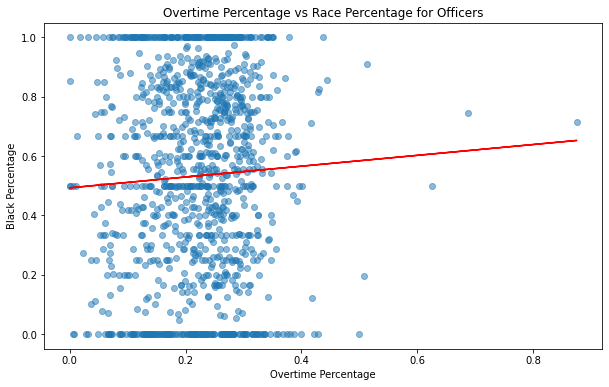

In [187]:
import matplotlib.pyplot as plt
import numpy as np

filtered_df = work_df[work_df['race_ratio'] >= 0]
filtered_df = filtered_df[filtered_df['race_ratio'] <= 1]

m, b = np.polyfit(filtered_df['overtime_ratio'], filtered_df['race_ratio'], 1)
print(f"Slope of the best fit line: {m}")

excluded_count = len(work_df) - len(filtered_df)
print(f"Number of data points excluded: {excluded_count}")

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['overtime_ratio'], filtered_df['race_ratio'], alpha=0.5)

m, b = np.polyfit(filtered_df['overtime_ratio'], filtered_df['race_ratio'], 1)
plt.plot(filtered_df['overtime_ratio'], m * filtered_df['overtime_ratio'] + b, color='red')

plt.xlabel('Overtime Percentage')
plt.ylabel('Black Percentage')
plt.title('Overtime Percentage vs Race Percentage for Officers')

plt.show()

Number of data points excluded: 1189


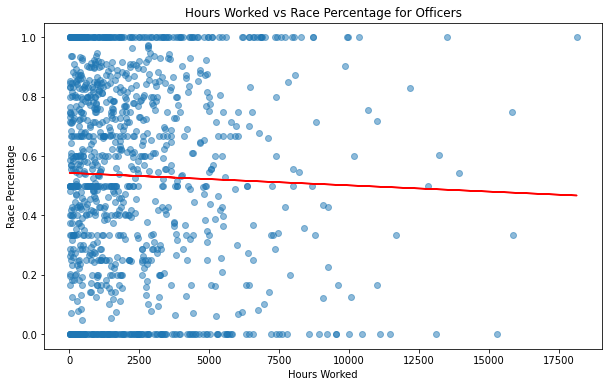

In [188]:
filtered_df = work_df[work_df['race_ratio'] >= 0]
filtered_df = filtered_df[filtered_df['race_ratio'] <= 1]
filtered_df = filtered_df[filtered_df['hours_paid'] > 0]

excluded_count = len(work_df) - len(filtered_df)
print(f"Number of data points excluded: {excluded_count}")

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['hours_paid'], filtered_df['race_ratio'], alpha=0.5)

m, b = np.polyfit(filtered_df['hours_paid'], filtered_df['race_ratio'], 1)
plt.plot(filtered_df['hours_paid'], m * filtered_df['hours_paid'] + b, color='red')

plt.xlabel('Hours Worked')
plt.ylabel('Race Percentage')
plt.title('Hours Worked vs Race Percentage for Officers')

plt.show()


Number of data points excluded: 834


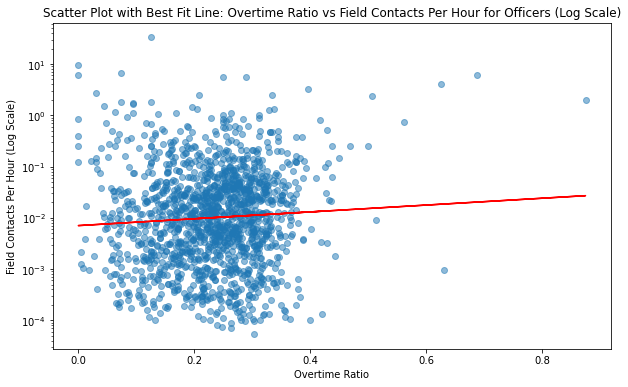

In [182]:
positive_contact_rate_df = work_df[work_df['contact_rate'] > 0]

excluded_count = len(work_df) - len(positive_contact_rate_df)
print(f"Number of data points excluded: {excluded_count}")

plt.figure(figsize=(10, 6))
plt.scatter(positive_contact_rate_df['overtime_ratio'], positive_contact_rate_df['contact_rate'], alpha=0.5)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Calculating the best fit line on the logarithmic scale
log_contact_rate = np.log(positive_contact_rate_df['contact_rate'])
m, b = np.polyfit(positive_contact_rate_df['overtime_ratio'], log_contact_rate, 1)

# Plot the best fit line, transforming it back to the original scale
plt.plot(positive_contact_rate_df['overtime_ratio'], np.exp(m * positive_contact_rate_df['overtime_ratio'] + b), color='red')

# Setting the labels and title
plt.xlabel('Overtime Ratio')
plt.ylabel('Field Contacts Per Hour (Log Scale)')
plt.title('Scatter Plot with Best Fit Line: Overtime Ratio vs Field Contacts Per Hour for Officers (Log Scale)')

# Show the plot
plt.show()


Number of data points excluded: 834


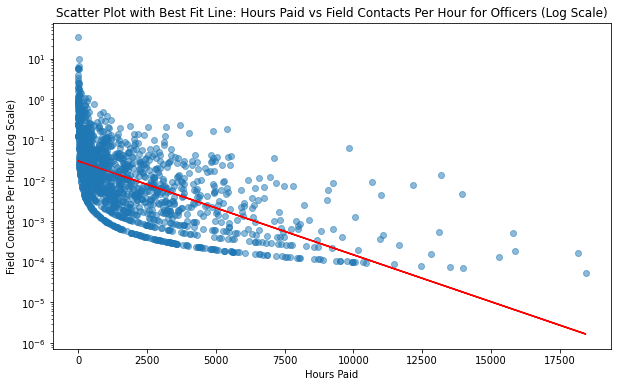

In [175]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out rows where contact_rate is greater than 400 and non-positive values
filtered_df = work_df[(work_df['contact_rate'] <= 4000) & (work_df['contact_rate'] >= 0)]
filtered_df = filtered_df[(filtered_df['hours_paid'] >= 0) & (filtered_df['contact_rate'] > 0)]

# Count the number of points excluded
excluded_count = len(work_df) - len(filtered_df)
print(f"Number of data points excluded: {excluded_count}")

plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['hours_paid'], filtered_df['contact_rate'], alpha=0.5)

# Set the y-axis to logarithmic scale
plt.yscale('log')

# Calculating the best fit line on the logarithmic scale
log_contact_rate = np.log(filtered_df['contact_rate'])
m, b = np.polyfit(filtered_df['hours_paid'], log_contact_rate, 1)

# Plot the best fit line, transforming it back to the original scale
plt.plot(filtered_df['hours_paid'], np.exp(m * filtered_df['hours_paid'] + b), color='red')

# Setting the labels and title
plt.xlabel('Hours Paid')
plt.ylabel('Field Contacts Per Hour (Log Scale)')
plt.title('Scatter Plot with Best Fit Line: Hours Paid vs Field Contacts Per Hour for Officers (Log Scale)')

# Show the plot
plt.show()
